In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.text import  *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from tqdm.notebook import tqdm
import transformers
from transformers import BertForSequenceClassification,BertTokenizer,AdamW,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
import random

In [3]:
df = pd.read_csv('/content/train_2kmZucJ.csv',)
df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [4]:
df['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [5]:
idx_train,idx_val,_,_ = train_test_split(df.index.values,df.label.values,test_size=0.15,random_state=10,stratify = df.label.values)
df['data_type'] = ['na']*df.shape[0]
df.loc[idx_train,"data_type"] = 'train'
df.loc[idx_val,"data_type"] = 'val'
idx_train[:10]

array([5198, 4607, 7130, 1469, 3418, 5355, 4002, 5876, 7282, 1009])

In [6]:
df.data_type.value_counts(), df[df['data_type'] == 'val']['label'].value_counts()

(train    6732
 val      1188
 Name: data_type, dtype: int64, 0    884
 1    304
 Name: label, dtype: int64)

In [7]:
df.head()

,id,label,tweet,data_type
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,val
1,2,0,Finally a transparant silicon case ^^ Thanks t...,train
2,3,0,We love this! Would you go? #talk #makememorie...,train
3,4,0,I'm wired I know I'm George I was made that wa...,train
4,5,1,What amazing service! Apple won't even talk to...,train


In [9]:
tweets = TextList.from_csv('/content','train_2kmZucJ.csv',cols='tweet').split_by_idxs(idx_train,idx_val).label_from_df(cols=1)
tweets

LabelLists;

Train: LabelList (6732 items)
x: TextList
xxbos xxmaj xxunk to the xxunk xxrep 4 ! xxmaj xxunk my xxunk up xxunk ! # movies # xxunk # xxunk # xxunk # xxunk # sony # marvel # spiderman # xxunk # xxunk # xxunk … https : / / www.instagram.com / p / xxunk / ? utm_source = xxunk …,xxbos xxmaj thanks # xxmaj apple for the $ 200 in gift cards ! ! ! xxunk and i will spend them xxunk !,xxbos xxmaj xxunk xxmaj why ca n't an iphone block numbers which call every day re xxunk etc . xxmaj was possible on an old xxmaj nokia xxunk,xxbos # new # samsung # galaxys5 # cool # fun # features xxmaj the next best thing is already here … http : / / instagram.com / p / xxunk /,xxbos xxmaj black and a blue .. # fun # birthday # xxunk # food # sushi # goodtimes # samsung # nxmini https : / / www.instagram.com / p / xxunk /
y: CategoryList
0,0,1,0,0
Path: /content;

Valid: LabelList (1188 items)
x: TextList
xxbos xxmaj follow @capetownsup on xxmaj instagram http : / / mf.tt / xxunk # sup # surf # fu

In [ ]:
tweets.train.x[1].text,tweets.train.x[1], tweets.train.y[1]

('xxbos xxmaj thanks # xxmaj apple for the $ 200 in gift cards ! ! ! xxunk and i will spend them xxunk !',
 Text [   2    5  161    9    5   16   31   21   55 2150   43  175 1695   15   15   15    0   28   18  136 1696  248    0
    15],
 Category 0)

In [ ]:
len(tweets.vocab.itos)

4000

In [ ]:
def doc_matrix_csr(text_list,n_terms):
  
  values = []
  column_ids = []
  row_pointer = []
  row_pointer.append(0)

  for _,doc in enumerate(text_list):
    feature_counter = Counter(doc.data)
    column_ids.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    row_pointer.append(len(values))
  
  return scipy.sparse.csr_matrix((values,column_ids,row_pointer), shape = (len(row_pointer)- 1,n_terms),dtype=int)

In [ ]:
train_doc_term = doc_matrix_csr(tweets.train.x,len(tweets.vocab.itos))
val_doc_term = doc_matrix_csr(tweets.valid.x,len(tweets.vocab.itos))
train_doc_term,val_doc_term

(<6732x4000 sparse matrix of type '<class 'numpy.int64'>'
 	with 146010 stored elements in Compressed Sparse Row format>,
 <1188x4000 sparse matrix of type '<class 'numpy.int64'>'
 	with 25466 stored elements in Compressed Sparse Row format>)

In [ ]:
vectorizer = CountVectorizer(preprocessor=noop, tokenizer=noop, max_features=800000)
train_docs = tweets.train.x
train_words = [[tweets.vocab.itos[o] for o in doc.data] for doc in train_docs]
train_doc_mat = vectorizer.fit_transform(train_words)
train_doc_mat

<6732x3992 sparse matrix of type '<class 'numpy.int64'>'
	with 146010 stored elements in Compressed Sparse Row format>

In [ ]:
valid_docs = tweets.valid.x
valid_words = [[tweets.vocab.itos[o] for o in doc.data] for doc in valid_docs]
val_doc_mat = vectorizer.transform(valid_words)
val_doc_mat

<1188x3992 sparse matrix of type '<class 'numpy.int64'>'
	with 25466 stored elements in Compressed Sparse Row format>

### **Naive Bayes**

In [ ]:
y_train = tweets.train.y.items
y_val = tweets.valid.y.items
x = train_doc_mat
x_val = val_doc_mat

#Train
p = (y_train ==  1).mean()
q = (y_train == 0).mean()
b = np.log(p/q)
print('bias : ',b)

C0 = np.squeeze(np.asarray(x[y_train == 0].sum(0)))
C1 = np.squeeze(np.asarray(x[y_train == 1].sum(0)))
L0 = (C0 + 1)/ ((y_train == 0).sum() + 1)
L1 = (C1 + 1)/ ((y_train == 1).sum() + 1)
R = np.log(L1/L0)
print('R: ',R)

preds_tr_freq = b + x@R > 0
pred_acc_freq = (preds_tr_freq == y_train).mean()

w = x.sign()
preds_tr = b + w@R > 0
pred_acc = (preds_tr == y_train).mean()

#Val

preds_val_freq = b + x_val@R > 0
val_acc_freq = (preds_val_freq == y_val).mean()

w_val = x_val.sign()
preds_val = b + w_val@R > 0
val_acc = (preds_val == y_val).mean()

bias :  -1.0679495090912345
R:  [-0.007088  1.137248 -1.366866  1.116359 ... -0.318726 -0.318726 -0.318726 -0.318726]


In [ ]:
print('train accuracy when considering frequency of occurence:  ',pred_acc_freq*100,'%','\n','train accuracy without considering frequency of occurence:  ',pred_acc*100,'%')
print('val accuracy when considering frequency of occurence:  ',val_acc_freq*100,'%','\n','val accuracy without considering frequency of occurence:  ',val_acc*100,'%')

train accuracy when considering frequency of occurence:   89.67617349970291 % 
 train accuracy without considering frequency of occurence:   89.26024955436719 %
val accuracy when considering frequency of occurence:   88.21548821548821 % 
 val accuracy without considering frequency of occurence:   87.2895622895623 %


In [ ]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=noop, tokenizer=noop, max_features=800000)
train_tfidf = tfidf_vectorizer.fit_transform(train_words)
val_tfidf = tfidf_vectorizer.transform(valid_words)
train_tfidf ,val_tfidf

(<6732x3992 sparse matrix of type '<class 'numpy.float64'>'
 	with 146010 stored elements in Compressed Sparse Row format>,
 <1188x3992 sparse matrix of type '<class 'numpy.float64'>'
 	with 25466 stored elements in Compressed Sparse Row format>)

In [ ]:
x_tf_tr = train_tfidf
x_tf_val = val_tfidf

#Train
C0_tf = np.squeeze(np.asarray(x_tf_tr[y_train == 0].sum(0)))
C1_tf = np.squeeze(np.asarray(x_tf_tr[y_train == 1].sum(0)))
L0_tf = (C0_tf + 1)/ ((y_train == 0).sum() + 1)
L1_tf = (C1_tf + 1)/ ((y_train == 1).sum() + 1)
R_tf = np.log(L1_tf/L0_tf)
print('R: ',R_tf)

tf_tr = b + x_tf_tr @R_tf > 0
tf_acc = (tf_tr == y_train).mean()

#Val

tf_val = b + x_tf_val@R > 0
tf_val_acc = (tf_val == y_val).mean()


R:  [ 0.008154  1.242648 -1.235326  1.272476 ...  0.528707  0.528707  0.437055  0.423579]


In [ ]:
print('train accuracy using tfidf:  ',tf_acc*100,'%')
print('val accuracy using tfidf:  ',tf_val_acc*100,'%')

train accuracy using tfidf:   89.23054070112893 %
val accuracy using tfidf:   88.55218855218855 %


### **Logistic Regression**

In [ ]:
log_reg = LogisticRegression()
param_grid= {'C':[1,0.1,0.01],'solver':['liblinear','lbfgs']}
grid = GridSearchCV(log_reg,param_grid=param_grid,cv=5,verbose=0)
grid.fit(train_tfidf,y_train)
print(grid.best_estimator_)
log_reg = grid.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
x_list = [train_doc_mat, train_doc_mat.sign(), train_tfidf]
x_val_list = [val_doc_mat, val_doc_mat.sign(), val_tfidf]
accuracy = [] # (train,val,train) as tuples_
for i in range(len(x_list)):
  log_reg.fit(x_list[i],y_train)
  acc_1 = (log_reg.predict(x_list[i]) == y_train).mean()*100
  acc_2 = (log_reg.predict(x_val_list[i]) == y_val).mean()*100
  accuracy.append((acc_1,acc_2))

   


In [ ]:
accuracy ,# count_vector, count_vector (No freq), tfidf

([(96.46464646464646, 88.88888888888889),
  (96.24183006535948, 88.97306397306397),
  (92.02317290552585, 89.73063973063972)],)

highest accuracy with tfidf

## **Transfer Learning**

In [32]:
df_test = pd.read_csv('test_oJQbWVk.csv')
df_test.head(),df_test.shape

(     id                                              tweet
 0  7921  I hate the new #iphone upgrade. Won't let me d...
 1  7922  currently shitting my fucking pants. #apple #i...
 2  7923  I'd like to puts some CD-ROMS on my iPad, is t...
 3  7924  My ipod is officially dead. I lost all my pict...
 4  7925  Been fighting iTunes all night! I only want th..., (1953, 2))

In [33]:
df_complete = pd.concat([df[['tweet']],df_test[['tweet']]])
assert df_complete.shape[0] == (df.shape[0] + df_test.shape[0])
df_complete.head(),df_complete.shape

(                                               tweet
 0  #fingerprint #Pregnancy Test https://goo.gl/h1...
 1  Finally a transparant silicon case ^^ Thanks t...
 2  We love this! Would you go? #talk #makememorie...
 3  I'm wired I know I'm George I was made that wa...
 4  What amazing service! Apple won't even talk to..., (9873, 1))

### Forward Model

In [34]:
data_lm = TextList.from_df(df=df_complete).split_by_rand_pct(0.1).label_for_lm().databunch(bs=48)

In [35]:
data_lm.show_batch()

idx,text
0,xxbos xxmaj we love this ! xxmaj would you go ? # talk # xxunk # xxunk # relax # iphone # smartphone # wifi # connect ... http : / / fb.me / xxunk xxbos i 'm wired i know i 'm xxmaj xxunk i was made that way ;) # iphone # cute # xxunk # home http : / / instagr.am / p / xxunk / xxbos
1,"life xxmaj july 10 , 2017 at 07:00 … xxbos xxmaj my ipads new home :) # ipad # xxunk # neon # ipad3 # apple http : / / instagram.com / p / xxunk / xxbos my # iphone # apps i can listen to drive time xxunk hop from xxup nyc whilst xxunk xxunk in my kitchen ! ! xxbos he loves the fuck outta me . xxunk"
2,"i do n't even have . xxmaj thanks # apple xxbos drinking coffee ! reading from http : / / bit.ly / simplebiblerox # free # iphone # app because # jesus is an awesome # god you all # xxunk :) xxbos xxmaj aww thank you so much ! "" xxunk : # xxup nowplaying xxmaj wake up next 2 you by xxunk just downloaded it and xxunk to"
3,"and the new iphone xxup 5s .. but wait , where 's the money # apple xxbos xxmaj shiny xxmaj new xxmaj apple xxmaj store about to open in xxmaj xxunk xxmaj upon xxmaj xxunk xxrep 4 . # apple # shiny # gadgets http : / / instagr.am / p / xxunk / xxbos xxmaj on the road # on # the # road # new # skirt #"
4,chargers are shit xxrep 5 ! xxbos xxmaj xxunk too long ... # graphicdesign # graphic # design # art # artwork # xxunk # iphone # apple … https : / / www.instagram.com / p / xxunk / xxbos xxunk xxmaj samsung galaxy s7 edge 32 gb xxunk # samsung # s7edge # occasion # smartphone # prixhappy … https : / / www.instagram.com / p / xxunk /


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


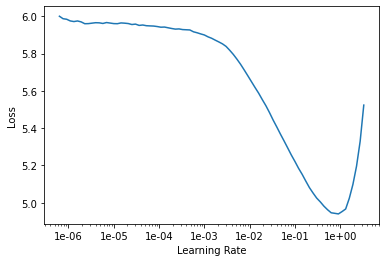

In [36]:
learn_lm = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.2)
learn_lm.lr_find()
learn_lm.recorder.plot()

In [37]:
learn_lm.fit_one_cycle(2,1e-01,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.473454,3.116028,0.468047,00:07
1,2.873942,2.868828,0.493047,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


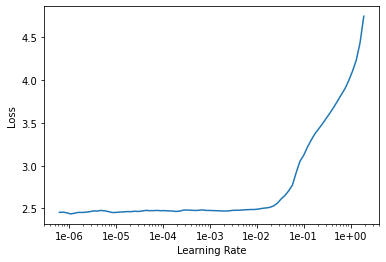

In [38]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [39]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_1')

epoch,train_loss,valid_loss,accuracy,time
0,2.396324,2.764595,0.507630,00:10


In [40]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_2')

epoch,train_loss,valid_loss,accuracy,time
0,2.252331,2.754094,0.512202,00:10


In [41]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_3')

epoch,train_loss,valid_loss,accuracy,time
0,2.080166,2.771522,0.515395,00:10


In [42]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_4')

epoch,train_loss,valid_loss,accuracy,time
0,1.932140,2.819533,0.515909,00:10


In [43]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_5')

epoch,train_loss,valid_loss,accuracy,time
0,1.779476,2.870682,0.514421,00:10


In [44]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_6')

epoch,train_loss,valid_loss,accuracy,time
0,1.626470,2.937575,0.513555,00:10


In [45]:
learn_lm.fit_one_cycle(1,1e-03,moms=(0.8,0.7))
learn_lm.save('lm_7')

epoch,train_loss,valid_loss,accuracy,time
0,1.469943,3.016369,0.511337,00:10


In [46]:
learn_lm.load('lm_5')
learn_lm.save_encoder('learn_enc')
learn_lm.data.vocab.save('vocab.pkl')

In [47]:
learn_lm.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 4824]           1,934,424  True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 1,934,424
Total trainable params: 1,934,424
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss func

In [49]:
data_cls = TextList.from_df(df,vocab=data_lm.vocab,cols='tweet').split_by_idxs(idx_train,idx_val).label_from_df(cols=1).databunch(bs=48)

In [50]:
data_cls.show_batch()

text,target
xxbos xxup xxunk xxmaj bluetooth xxmaj smartwatch xxmaj smart xxmaj watch with xxup sim xxmaj card xxmaj slot and xxup xxunk xxmaj camera for iphone / xxmaj samsung and xxmaj android xxmaj phones https : / / xxunk / products / xxunk - smartwatch - smart - watch - with - sim - card - slot - xxunk - xxunk - camera - for - iphone - samsung - and,0
xxbos xxmaj two xxmaj days to xxmaj xxunk xxmaj samsung xxmaj galaxy xxup s9 - xxmaj main xxmaj xxunk xxmaj we xxmaj know xxmaj so xxmaj far # great # news # joy # tech # information # innovation # creative # service # samsung # galaxys9 # xxunk # mobile # xxunk # android # nextbigthing # camera # nice # wireless # future https : / / techinwire.com,0
xxbos xxmaj two xxmaj smartphone xxmaj kings - xxmaj pros & xxmaj cons for xxmaj real ( xxmaj part i - iphone x ) # apple # iphone # iphonex # ios # ios11 # new # mobile # smartphones # app # faceid # xxunk # applepay # camera # portrait # battery # game # gaming # sound # video # quality # xxunk https : / /,0
"xxbos xxmaj sleep : a xxmaj key xxmaj xxunk to xxmaj happy , xxmaj healthy and xxmaj productive xxmaj lives .. https : / / xxunk / monthly - xxunk / health - link - new / xxunk - a - key - xxunk - to - happy - healthy - and - productive - lives … # productive # healthy # health # glad # smile # xxunk #",0
xxbos xxmaj best xxmaj voice xxmaj assistant xxmaj on xxmaj your xxmaj phone # xxmaj best # xxmaj voice # xxmaj assistant # xxmaj phone # ai # iot # xxunk # siri # apple # iphone # iphonex # iphone8 # newiphone # ios # android # mobile # tech # trend # tech # funny # search # yahoo # new # kid # xxunk # fancy #,0


In [51]:
learn_cls = text_classifier_learner(data_cls,AWD_LSTM,drop_mult=0.4)

In [52]:
learn_cls.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [46, 400]            0          False     
______________________________________________________________________
RNNDropout           [46, 1152]           0          False     
______________________________________________________________________
RNNDropout           [46, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [53]:
learn_cls.load_encoder('learn_enc')
pass

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


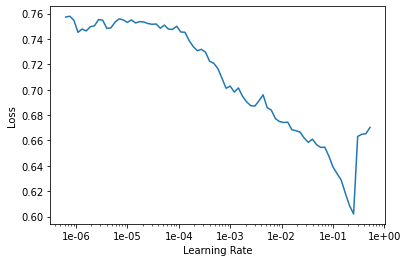

In [54]:
learn_cls.lr_find()
learn_cls.recorder.plot(skip_end = 10)

In [55]:
learn_cls.fit_one_cycle(1,6e-02,moms = (0.8,0.7))
learn_cls.save('cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.459362,0.282753,0.890572,00:04


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


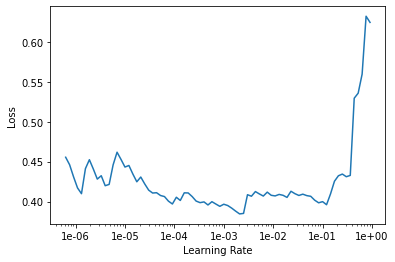

In [56]:
learn_cls.freeze_to(-2)
learn_cls.lr_find()
learn_cls.recorder.plot()

In [57]:
learn_cls.fit_one_cycle(1,slice(1e-02/(2.6**4),1e-02),moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.362998,0.284808,0.888889,00:04


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


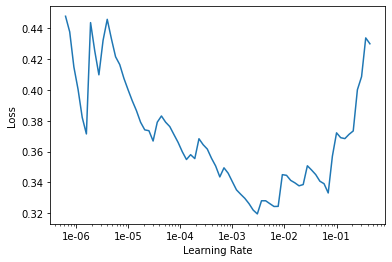

In [58]:
learn_cls.freeze_to(-3)
learn_cls.lr_find()
learn_cls.recorder.plot()

In [59]:
learn_cls.fit_one_cycle(1,slice(2e-02/(2.6**4),2e-02),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.364843,0.284119,0.884680,00:07


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


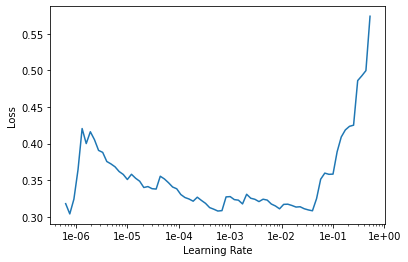

In [60]:
learn_cls.unfreeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [61]:
learn_cls.fit_one_cycle(2,slice(2e-03/(2.6**4),2e-03),moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.258801,0.238377,0.905724,00:09
1,0.238910,0.241208,0.904882,00:08


In [62]:
learn_cls.save('cls_2')

In [104]:
learn_cls.fit_one_cycle(1,slice(2e-03/(2.6**4),2e-03),moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.209934,0.234210,0.909091,00:09


In [105]:
learn_cls.save('cls_3')

In [184]:
preds_train,tr_targ = learn_cls.get_preds(ds_type = DatasetType.Train.value,ordered=True)
(np.argmax(preds_train,axis=1) == tr_targ).float().mean()*100

tensor(95.6774)

In [106]:
learn_cls.load('cls_3')
pass

### Backwards Model

In [66]:
data_lm_bwd = TextList.from_df(df=df_complete).split_by_rand_pct(0.1).label_for_lm().databunch(bs=48,backwards=True)
data_lm_bwd.show_batch()

idx,text
0,could you if xxmaj . screen the across right crack a goes there xxmaj xxbos discount # music # case # iphone # … tweet = tweet&utm_medium = social_autopilot&utm_source = xxunk / products / zetasupplies.co.uk / / : http - here out it check xxmaj . hoodie xxmaj - available xxmaj now xxmaj xxbos … xxunk - old - xxunk - xxunk - galaxy - samsung / xxunk / /
1,xxmaj . nice be to this saying just not 'm i xxbos / xxunk / p / instagram.com / / : http … sad # cry # xxunk # xxunk # lol # cute # imessage # iphone # text # boyfriend # ex # ex from xxmaj xxbos iphone today up screwing just is apple xxmaj with do to everything god to swear xxmaj xxbos apple # . else
2,"# samsung xxmaj # . user apple an longer no xxmaj xxbos developers # apple # ipad # iphone # xxunk / bit.ly / / : http . away days of xxunk also is xxunk xxunk xxup ios8 # means that by officially , so xxmaj xxbos xxunk # a sougofollow # iphone # gain xxmaj rts who everyone follow xxmaj back xxup follow xxup i me xxup follow xxup"
3,# iphone # valentineday # poem daughter # nowplaying # photography # … id809353957?mt=8 / love360 / app / us / itunes.apple.com / / : https > > app xxmaj sweet xxmaj with xxmaj love xxmaj sweet xxmaj xxbos / xxunk / p / instagr.am / / : http insane xxunk @ xxunk # apple # iphone # xxunk # bitches # xxunk # . xxunk xxunk quit xxmaj xxbos
4,tfpshooting # tfpmodel # tfp # shooting # shoot # portrait # shot xxmaj street xxmaj xxbos xxunk # iphone # nature xxmaj # autumn xxmaj # colour # … xxunk / app / itunes.apple.com / / : https xxunk # . it of heard never ? straight xxbos / xxunk / p / instagram.com / / : http xxunk # sony xxmaj # excited # hehe xxmaj .. dad


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


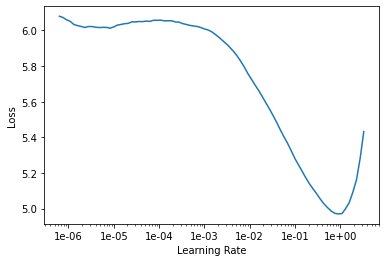

In [67]:
learn_lm_bwd = language_model_learner(data_lm_bwd,AWD_LSTM,drop_mult=0.2)
learn_lm_bwd.lr_find()
learn_lm_bwd.recorder.plot()

In [68]:
learn_lm_bwd.fit_one_cycle(2,1e-01,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.484113,3.035897,0.491098,00:07
1,2.864553,2.781638,0.522024,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


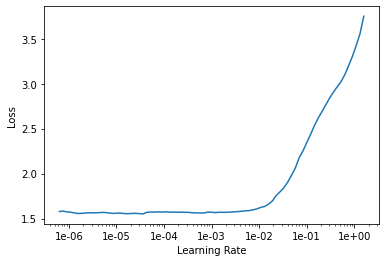

In [69]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [70]:
learn_lm_bwd.fit_one_cycle(5,1e-03,moms=(0.8,0.7))
learn_lm_bwd.save('lm_bwd')

epoch,train_loss,valid_loss,accuracy,time
0,2.455741,2.779831,0.522565,00:07
1,2.426029,2.776175,0.524107,00:07
2,2.412840,2.768039,0.524567,00:07
3,2.383685,2.767607,0.524188,00:07
4,2.363574,2.767284,0.524459,00:07


In [71]:
learn_lm_bwd.save_encoder('learn_bwd_enc')

In [72]:
data_cls_bwd = TextList.from_df(df,vocab=data_lm_bwd.vocab,cols='tweet').split_by_idxs(idx_train,idx_val).label_from_df(cols=1).databunch(bs=48,backwards=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


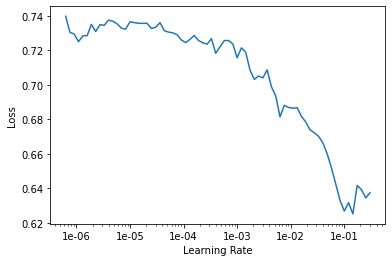

In [73]:
learn_cls_bwd = text_classifier_learner(data_cls_bwd,AWD_LSTM,drop_mult=0.4)
learn_cls_bwd.load_encoder('learn_bwd_enc')
learn_cls_bwd.lr_find()
learn_cls_bwd.recorder.plot(skip_end = 10)

In [74]:
learn_cls_bwd.fit_one_cycle(1,6e-02,moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.440982,0.295128,0.872896,00:04


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


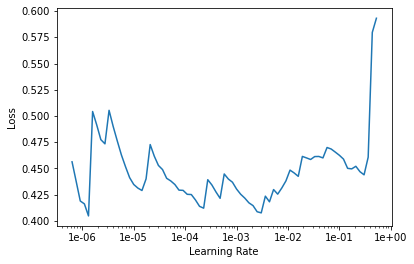

In [75]:
learn_cls_bwd.freeze_to(-2)
learn_cls_bwd.lr_find()
learn_cls_bwd.recorder.plot()

In [76]:
learn_cls_bwd.fit_one_cycle(1,slice(1e-02/(2.6**4),1e-02),moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.419087,0.283526,0.880471,00:04


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


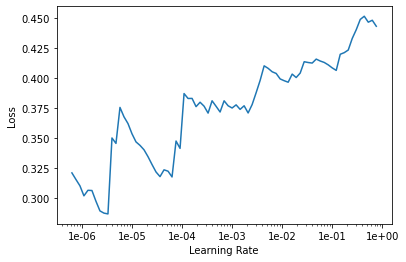

In [77]:
learn_cls_bwd.freeze_to(-3)
learn_cls_bwd.lr_find()
learn_cls_bwd.recorder.plot()

In [78]:
learn_cls_bwd.fit_one_cycle(1,slice(2e-02/(2.6**4),2e-02),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.367994,0.266179,0.889731,00:06


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


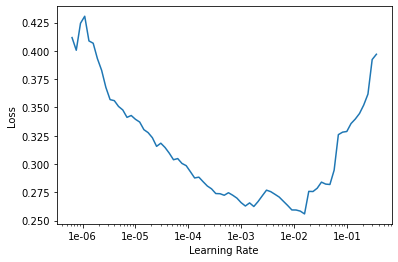

In [79]:
learn_cls_bwd.unfreeze()
learn_cls_bwd.lr_find()
learn_cls_bwd.recorder.plot()

In [80]:
learn_cls_bwd.fit_one_cycle(2,slice(2e-03/(2.6**4),2e-03),moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.254414,0.238702,0.902357,00:09
1,0.238728,0.236004,0.906566,00:09


In [81]:
learn_cls_bwd.save('cls_bwd_2')

In [183]:
preds_bwd_train,tr_targ = learn_cls_bwd.get_preds(ds_type = DatasetType.Train.value,ordered=True)
(np.argmax(preds_bwd_train,axis=1) == tr_targ).float().mean()*100

tensor(93.0333)

In [85]:
#Backwards = 90.65 %
#Forwards = 90.90%

### Ensemble

In [107]:
preds,targs = learn_cls.get_preds(ordered=True)
(np.argmax(preds,axis=1) == targs).float().mean()*100

tensor(90.9091)

In [108]:
preds_bwd,targs = learn_cls_bwd.get_preds(ordered=True)
(np.argmax(preds_bwd,axis=1) == targs).float().mean()*100

tensor(90.6566)

In [109]:
preds_avg = (preds+preds_bwd)/2
(np.argmax(preds_avg,axis=1) == targs).float().mean()*100

tensor(91.2458)

In [110]:
#about 91.246%

## **BERT**

In [155]:
df.head()

,id,label,tweet,data_type
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,val
1,2,0,Finally a transparant silicon case ^^ Thanks t...,train
2,3,0,We love this! Would you go? #talk #makememorie...,train
3,4,0,I'm wired I know I'm George I was made that wa...,train
4,5,1,What amazing service! Apple won't even talk to...,train


In [156]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [157]:
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].tweet.values,
                                                 add_special_tokens = True,
                                                 return_attention_mask=True,
                                                 pad_to_max_length =True,
                                                 max_length = 300, #Max Characters in a tweet
                                                 return_tensors = 'pt',
                                                 ) 

encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].tweet.values,
                                                 add_special_tokens = True,
                                                 return_attention_mask=True,
                                                 pad_to_max_length =True,
                                                 max_length = 300, #Max Characters in a tweet
                                                 return_tensors = 'pt',
                                                 ) 

input_ids_train = encoded_data_train['input_ids']
attention_mask_train = encoded_data_train['attention_mask']
label_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_mask_val = encoded_data_val['attention_mask']
label_val = torch.tensor(df[df.data_type == 'val'].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [158]:
dataset_train = TensorDataset(input_ids_train,attention_mask_train,label_train)
dataset_val = TensorDataset(input_ids_val,attention_mask_val,label_val)

In [159]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2,
                                                      output_attentions=False,output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [160]:
bs = 32
dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train),batch_size=bs)
dataloader_val = DataLoader(dataset_val,sampler = SequentialSampler(dataset_val),batch_size=bs)

In [161]:
epochs = 4
optimizer = AdamW(model.parameters(),lr = 3e-05,eps=1e-07)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                            num_training_steps= len(dataloader_train)*epochs)

In [162]:
def accuracy(preds,labels):
  preds_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return (preds_flat == labels_flat).mean()

In [163]:
seed_val = 10
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [165]:
def evaluate(dataloader):
  model.eval()
  loss_val_total = 0
  preds,true_labels = [],[]
  
  for batch in dataloader:
    batch = tuple(b.to(device) for b in batch)
    inputs  = {'input_ids': batch[0], 'attention_mask' : batch[1], 'labels' : batch[2] }
    with torch.no_grad():
      outputs = model(**inputs)
    
    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].detach().cpu().numpy()
    preds.append(logits)
    true_labels.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader_val) 
    
  preds = np.concatenate(preds, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)
            
  return loss_val_avg, preds, true_labels


In [166]:
for epoch in tqdm(range(1, epochs+1)):

  model.train()

  loss_train_total = 0

  progress_bar = tqdm(dataloader_train,desc='Epoch {:1d}'.format(epoch),leave=False,disable=False)

  for batch in progress_bar:
    model.zero_grad()
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0],'attention_mask': batch[1],'labels': batch[2]}
    outputs = model(**inputs)

    loss= outputs[0]
    loss_train_total += loss.item()
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(),1.0)

    optimizer.step()
    scheduler.step()
    
    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
  torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
  tqdm.write(f'\nEpoch {epoch}')

  loss_train_avg = loss_train_total/len(dataloader_train)            
  tqdm.write(f'Training loss: {loss_train_avg}')
    
  val_loss, preds, true_labels = evaluate(dataloader_val)
  val_acc = accuracy(preds,true_labels)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'Accuracy Score : {val_acc}')



Epoch 1
Training loss: 0.2452758473136696
Validation loss: 0.2173758941261392
Accuracy Score : 0.9074074074074074



Epoch 2
Training loss: 0.15863196799858204
Validation loss: 0.210863076836655
Accuracy Score : 0.9175084175084175



Epoch 3
Training loss: 0.09676696529603117
Validation loss: 0.281994815866806
Accuracy Score : 0.914983164983165



Epoch 4
Training loss: 0.05786626898105393
Validation loss: 0.31738370044254943
Accuracy Score : 0.914983164983165



In [187]:
tr_loss, tr_preds, true_labels = evaluate(dataloader_train)
tr_acc = accuracy(tr_preds,true_labels)
tr_acc

0.9649435531788473

# Test

In [111]:
df_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [112]:
df_sample = pd.read_csv('sample_submission_LnhVWA4.csv',index_col='id')
df_sample.head()

,label
id,
7921,0
7922,0
7923,0
7924,0
7925,0


### Naive Bayes

In [ ]:
tweets_test = TextList.from_df(df_test,cols='tweet',vocab=tweets.vocab).split_none().label_empty()
tweets_test

In [ ]:
len(tweets_test.vocab.itos)

4000

In [ ]:
test_docs = tweets_test.train.x
test_words = [[tweets_test.vocab.itos[o] for o in doc.data] for doc in test_docs]
test_doc_mat = vectorizer.transform(test_words)
test_doc_tfidf = tfidf_vectorizer.transform(test_words)


In [ ]:
x_test = test_doc_mat
w_test = test_doc_mat.sign()
test_nb_occ = (b + w_test@R > 0)*1
test_nb_cv =  (b + x_test@R > 0)*1
test_nb_tf = (b + test_doc_tfidf@R_tf > 0)*1
len(test_nb_tf),len(test_nb_cv)

(1953, 1953)

In [ ]:
df_sample['label'] = test_nb_cv
df_sample.to_csv('cv_NB')

df_sample['label'] = test_nb_occ
df_sample.to_csv('occ_NB')

df_sample['label'] = test_nb_tf
df_sample.to_csv('tf_NB')

In [ ]:
df_sample.head()

,label
id,
7921,1
7922,0
7923,1
7924,1
7925,1


### Logistic Regression

In [ ]:
x_test_list = [test_doc_mat, val_doc_mat.sign(), test_doc_tfidf]
preds_list = []
for a in range(len(x_list)):
  log_reg.fit(x_list[i],y_train)
  preds_list.append(log_reg.predict(x_test_list[i]))

In [ ]:
df_sample['label'] = preds_list[0]
df_sample.to_csv('cv_LR')

df_sample['label'] = preds_list[1]
df_sample.to_csv('occ_LR')

df_sample['label'] = preds_list[2]
df_sample.to_csv('tf_LR')

### AWD_LSTM

In [113]:
tweets_tst = TextList.from_df(df_test,cols='tweet')

In [119]:
data_cls = TextList.from_df(df,vocab= data_lm.vocab,cols='tweet').split_by_idxs(idx_train,idx_val).label_from_df(cols=1).add_test(tweets_tst).databunch(bs=48)


In [120]:
learn_cls = text_classifier_learner(data_cls,AWD_LSTM,drop_mult=0.4)
learn_cls.load('cls_3')
pass


In [121]:
preds_fwd_,_ = learn_cls.get_preds(ds_type= DatasetType.Test,ordered=True)
preds_fwd = preds_fwd_.numpy()
preds_fwd = np.argmax(preds_fwd,axis=1)

In [122]:
data_cls_bwd = TextList.from_df(df,vocab=data_lm_bwd.vocab,cols='tweet').split_by_idxs(idx_train,idx_val).label_from_df(cols=1).add_test(tweets_tst).databunch(bs=48,backwards=True)

In [125]:
learn_cls_bwd = text_classifier_learner(data_cls_bwd,AWD_LSTM,drop_mult=0.4)

In [126]:
learn_cls_bwd.load('cls_bwd_2')
pass

In [127]:
preds_bwd_,_ = learn_cls_bwd.get_preds(ds_type= DatasetType.Test,ordered=True)
preds_bwd = preds_bwd_.numpy()
preds_bwd = np.argmax(preds_bwd,axis=1)

In [128]:
preds_ensemble = (preds_bwd_+preds_fwd_)/2
preds_ensemble = preds_ensemble.numpy()
preds_ensemble = np.argmax(preds_ensemble,axis=1)

In [130]:
df_sample['label'] = preds_fwd
df_sample.to_csv('LSTM_fwd.csv')

df_sample['label'] = preds_bwd
df_sample.to_csv('LSTM_bwd.csv')

df_sample['label'] = preds_ensemble
df_sample.to_csv('LSTM_ens.csv')

### BERT

In [167]:
encoded_data_test = tokenizer.batch_encode_plus(df_test.tweet.values,
                                                 add_special_tokens = True,
                                                 return_attention_mask=True,
                                                 pad_to_max_length =True,
                                                 max_length = 300, #Max Characters in a tweet
                                                 return_tensors = 'pt',
                                                 ) 

input_ids_test = encoded_data_test['input_ids']
attention_mask_test = encoded_data_test['attention_mask']
dataset_test = TensorDataset(input_ids_test,attention_mask_test)   

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [168]:
dataloader_test = DataLoader(dataset_test,sampler=SequentialSampler(dataset_test),batch_size=48)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2,
                                                      output_attentions=False,output_hidden_states=False)

In [169]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_2.model'))
model = model.to(device)

In [170]:
def predict(dataloader):
  model.eval()
  loss_test_total = 0
  preds = []

  for batch in dataloader:
    batch = tuple(b.to(device) for b in batch) 
    inputs = {
              "input_ids" : batch[0],
              "attention_mask" : batch[1]
              }
    
    with torch.no_grad():
      outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    preds.append(logits)
  
  preds = np.concatenate(preds,axis=0)
 
  return preds

In [171]:
test_preds=  predict(dataloader_test)

In [172]:
test_preds_flat = np.argmax(test_preds,axis=1).flatten()
test_preds_flat[:5]

array([1, 1, 1, 1, 1])

In [173]:
df_sample['label'] = test_preds_flat
df_sample.to_csv('Bert.csv')

# Results

In [2]:
pd.read_excel('Results.xlsx')

,Model,Train Accuracy,Val Accuracy,Test Accucary
0,"Naïve Bayes - spacy tokenization, countvector",89.676,88.210,87.648
1,"Naïve Bayes - spacy tokenization, countvector,...",89.260,87.290,86.294
2,"Naïve Bayes - spacy tokenization, tfidf",89.230,88.550,89.294
3,"Logistic Regression - spacy tokenization, coun...",96.460,88.880,88.123
4,"Logistic Regression - spacy tokenization, coun...",96.240,88.970,88.123
5,"Logistic Regression - spacy tokenization, tfidf",92.023,89.730,88.123
6,"AWD-LSTM, transfer learning, fwd",95.677,90.909,88.540
7,"AWD-LSTM, transfer learning, bwd",93.033,90.656,89.310
8,"AWD-LSTM, transfer learning, ensemble",NaN,91.245,89.310
9,Pre-Trained Bert,96.490,91.750,91.158
